<a href="https://colab.research.google.com/github/drandrewwilliams/andrewbwilliamsphd/blob/master/AI4DM2Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn fairlearn aif360



In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import CalibratedEqualizedOdds

pip install 'aif360[inFairness]'


ImportError: cannot import name 'CalibratedEqualizedOdds' from 'aif360.algorithms.postprocessing' (/usr/local/lib/python3.11/dist-packages/aif360/algorithms/postprocessing/__init__.py)

In [4]:
!pip install aif360

In [21]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (12, 8)

In [23]:
# Part 1: Understanding Bias in AI

## Types of Bias in AI Systems

#AI systems can be affected by various types of bias. Let's explore the main categories:

#1. **Historical Bias**: Occurs when the data reflects past prejudices or societal inequalities
#2. **Representation Bias**: When certain groups are underrepresented in the training data
#3. **Measurement Bias**: Due to how features are defined or measured
#4. **Aggregation Bias**: When models work well for dominant groups but fail for minority groups
#5. **Evaluation Bias**: When testing/validation data or metrics don't represent real-world conditions
#6. **Deployment Bias**: Emerges from how models are implemented and used in practice

## Reflection Questions

#**Complete the following reflection questions:**

#1. How might each type of bias manifest in a project management context?
#2. What are the potential consequences of unaddressed bias in business decision-making systems?
#3. What stakeholders might be affected differently by these biases?

#*Your answers here:*

# Part 2: Bias Detection

#Let's work with the Adult Income Census dataset, which is commonly used to predict whether an individual earns more than $50,000 per year based on demographic and employment information.

## Data Loading and Exploration

In [8]:
from sklearn.datasets import fetch_openml

# Fetch the Adult Census Income dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
X = adult.data
y = adult.target

# Preview the data
print("Dataset shape:", X.shape)
X.head()

Dataset shape: (48842, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [9]:
# Examine the target variable
print("Target distribution:")
print(y.value_counts(normalize=True))

Target distribution:
class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64


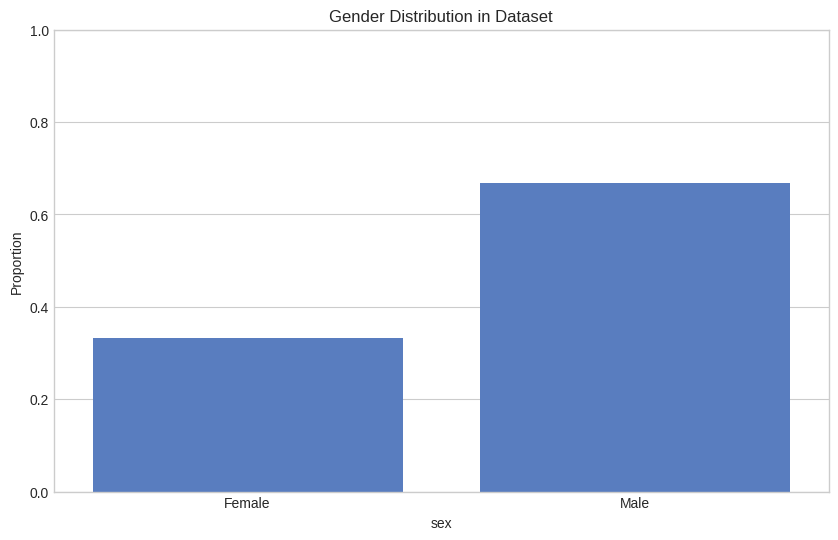

In [10]:
# Convert categorical variables to pandas category type
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

# Analyze gender distribution
gender_distribution = X['sex'].value_counts(normalize=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values)
plt.title('Gender Distribution in Dataset')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.show()

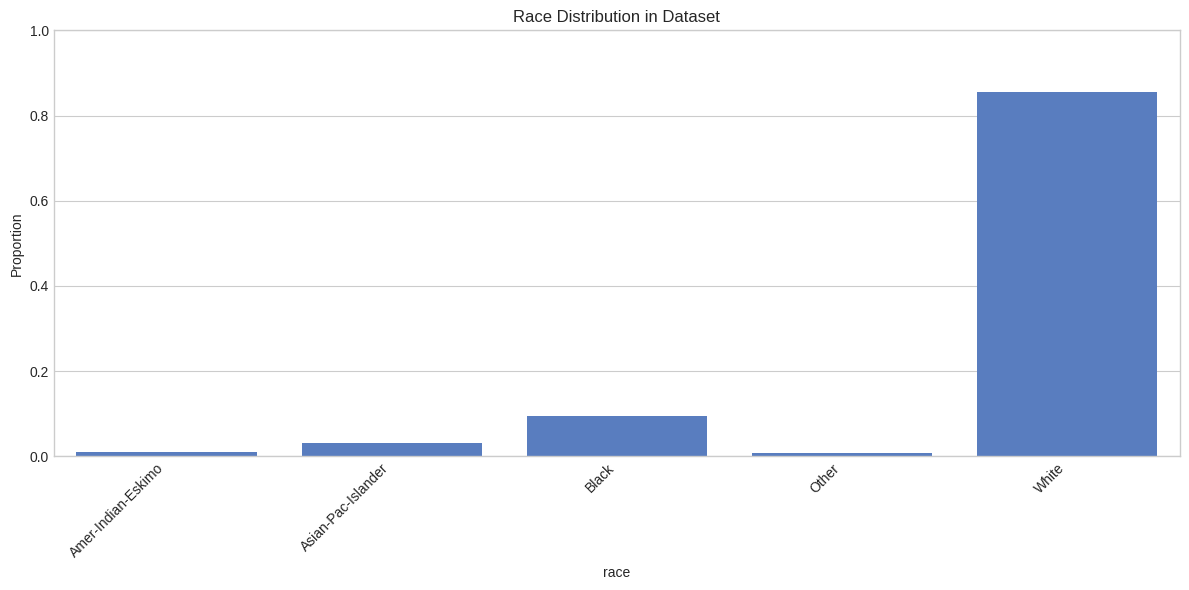

In [11]:
# Analyze race distribution
race_distribution = X['race'].value_counts(normalize=True)
plt.figure(figsize=(12, 6))
sns.barplot(x=race_distribution.index, y=race_distribution.values)
plt.title('Race Distribution in Dataset')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [12]:
# Calculate representation ratio for gender (compared to overall population)
total_high_income = (y == '>50K').mean()
high_income_by_gender = y.groupby(X['sex']).apply(lambda x: (x == '>50K').mean())
gender_representation_ratio = high_income_by_gender / total_high_income

print("Gender representation ratio in high income group:")
print(gender_representation_ratio)

# Calculate representation ratio for race
high_income_by_race = y.groupby(X['race']).apply(lambda x: (x == '>50K').mean())
race_representation_ratio = high_income_by_race / total_high_income

print("\nRace representation ratio in high income group:")
print(race_representation_ratio)

Gender representation ratio in high income group:
sex
Female    0.456581
Male      1.269496
Name: class, dtype: float64

Race representation ratio in high income group:
race
Amer-Indian-Eskimo    0.489052
Asian-Pac-Islander    1.125268
Black                 0.504891
Other                 0.514677
White                 1.061455
Name: class, dtype: float64


<ipython-input-12-b6723e20e849>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_income_by_gender = y.groupby(X['sex']).apply(lambda x: (x == '>50K').mean())
<ipython-input-12-b6723e20e849>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_income_by_race = y.groupby(X['race']).apply(lambda x: (x == '>50K').mean())


In [13]:
# Prepare the dataset for modeling
# Convert categorical features to one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Store sensitive attributes for fairness evaluation
gender = X['sex'] == 'Female'  # 1 for Female, 0 for Male
race = X['race'] == 'Black'    # 1 for Black, 0 for others (simplified for this exercise)

# Convert target to binary (1 for income >50K, 0 for <=50K)
y_binary = (y == '>50K').astype(int)

# Split the data
X_train, X_test, y_train, y_test, gender_train, gender_test, race_train, race_test = train_test_split(
    X_encoded, y_binary, gender, race, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [14]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [15]:
# Train a simple logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate overall model performance
print("Overall model accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Overall model accuracy: 0.8569966219674481

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7479
           1       0.74      0.61      0.67      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769



In [16]:
# Evaluate performance by gender
female_idx = gender_test
male_idx = ~gender_test

print("Performance for females:")
print("Accuracy:", accuracy_score(y_test[female_idx], y_pred[female_idx]))
print("Positive prediction rate:", y_pred[female_idx].mean())

print("\nPerformance for males:")
print("Accuracy:", accuracy_score(y_test[male_idx], y_pred[male_idx]))
print("Positive prediction rate:", y_pred[male_idx].mean())

# Calculate fairness metrics
print("\nFairness Metrics:")
print("Demographic Parity Difference (Gender):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred,
                                   sensitive_features=gender_test))

Performance for females:
Accuracy: 0.9376918354818907
Positive prediction rate: 0.07305095150399017

Performance for males:
Accuracy: 0.8166180310244202
Positive prediction rate: 0.2544923974811857

Fairness Metrics:
Demographic Parity Difference (Gender): 0.18144144597719553


In [17]:
# Evaluate performance by race
black_idx = race_test
other_race_idx = ~race_test

print("Performance for Black individuals:")
print("Accuracy:", accuracy_score(y_test[black_idx], y_pred[black_idx]))
print("Positive prediction rate:", y_pred[black_idx].mean())

print("\nPerformance for other races:")
print("Accuracy:", accuracy_score(y_test[other_race_idx], y_pred[other_race_idx]))
print("Positive prediction rate:", y_pred[other_race_idx].mean())

# Calculate fairness metrics
print("\nFairness Metrics:")
print("Demographic Parity Difference (Race):",
      demographic_parity_difference(y_true=y_test,
                                   y_pred=y_pred,
                                   sensitive_features=race_test))

Performance for Black individuals:
Accuracy: 0.9223205506391348
Positive prediction rate: 0.07571288102261553

Performance for other races:
Accuracy: 0.8494058500914077
Positive prediction rate: 0.20772394881170017

Fairness Metrics:
Demographic Parity Difference (Race): 0.13201106778908464


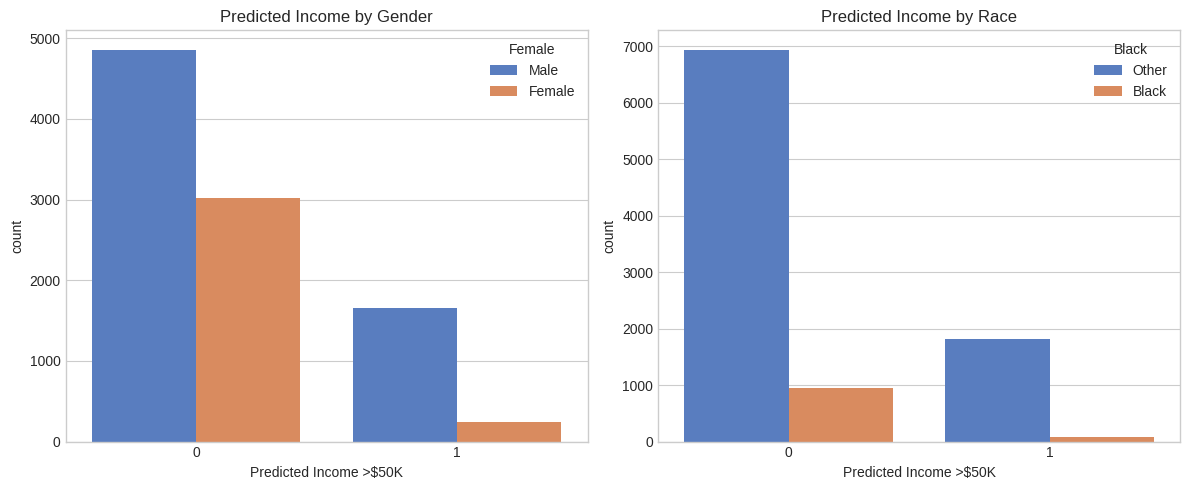

In [18]:
# Visualize prediction distributions by gender
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_pred, hue=gender_test)
plt.title('Predicted Income by Gender')
plt.xlabel('Predicted Income >$50K')
plt.legend(title='Female', labels=['Male', 'Female'])

# Visualize prediction distributions by race
plt.subplot(1, 2, 2)
sns.countplot(x=y_pred, hue=race_test)
plt.title('Predicted Income by Race')
plt.xlabel('Predicted Income >$50K')
plt.legend(title='Black', labels=['Other', 'Black'])

plt.tight_layout()
plt.show()

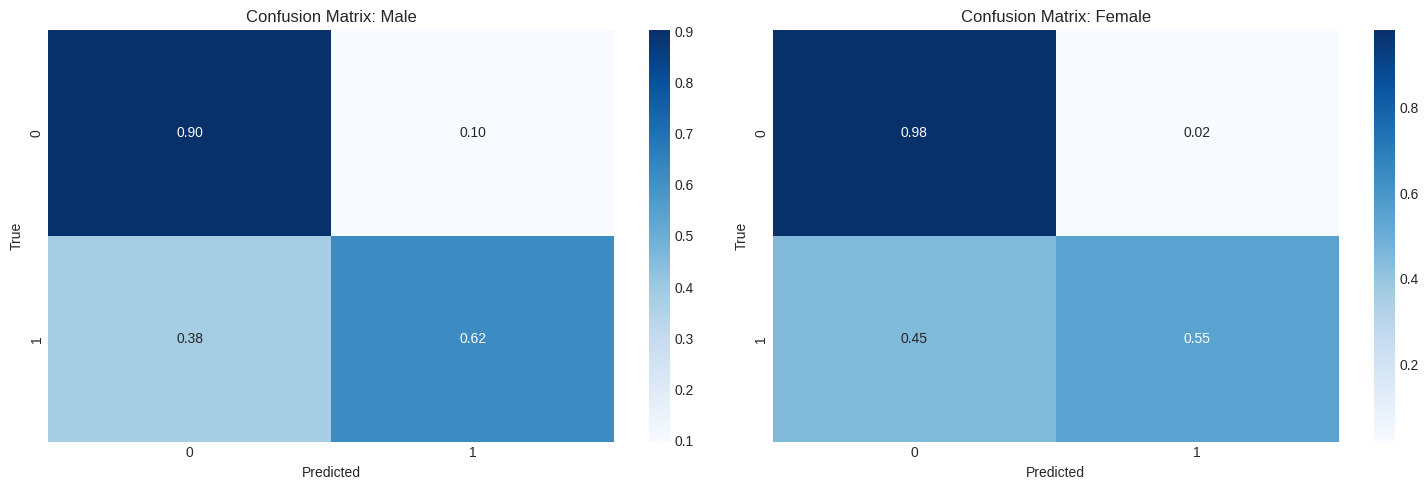

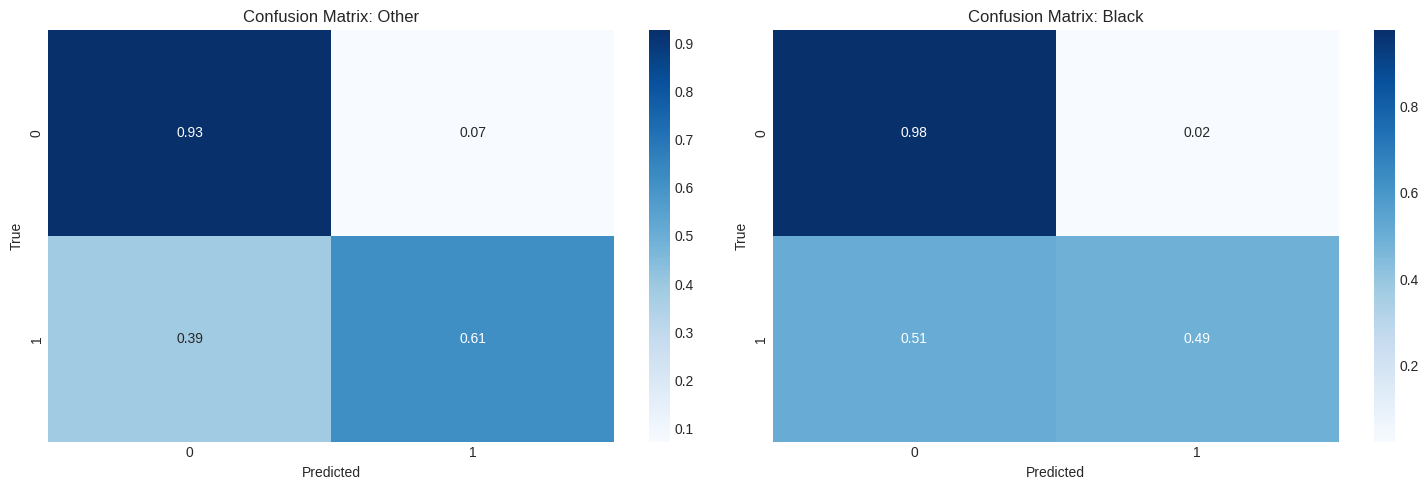

In [19]:
# Create a confusion matrix for each group
def plot_confusion_matrices(y_true, y_pred, protected_attribute, group_names):
    fig, axes = plt.subplots(1, len(group_names), figsize=(15, 5))

    for i, name in enumerate(group_names):
        if i == 0:
            idx = ~protected_attribute
        else:
            idx = protected_attribute

        cm = confusion_matrix(y_true[idx], y_pred[idx], normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

# Plot confusion matrices by gender
plot_confusion_matrices(y_test, y_pred, gender_test, ['Male', 'Female'])

# Plot confusion matrices by race
plot_confusion_matrices(y_test, y_pred, race_test, ['Other', 'Black'])

In [20]:
# Part 3: Bias Mitigation Techniques